In [75]:
#The purpose of this script is to parse the raw clipper output to windows and pass the actual RT stops through these windows to work with the RT stops directly

#NOTE - this script uses the file used to make the bam file for clipper. need to find the original file used to make the bam file

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline

In [76]:
#Need to filter the mergedRT of snoRNAs and miRNAs
def filter_snoRNAs(negAndPosMerged, snoRNAmasker, miRNAmasker):
	# Usage: Filter snoRNA and miRNAs from protein coding reads.
	# Input: .bed file with protein coding reads.
	# Output: snoRNA and miR filtered .bed file.
	program='intersectBed'
	proteinWithoutmiRNAs = negAndPosMerged.replace('.bed','_snoRNAremoved_miRNAremoved.bed')

	cmd1 = "bedtools intersect -a {} -b {} -wa -v -s | sort -k1,1 -k2,2n".format(negAndPosMerged, snoRNAmasker)
	cmd2_1 = "bedtools intersect -a - -b {} -wa -v -s -sorted".format(miRNAmasker)
	cmd2_2 = "awk -F '\\t' 'BEGIN {OFS=\"\\t\"} {print $1,$2,$3,$4 \"_\" NR,$5,$6}'"
	cmd2_3 = proteinWithoutmiRNAs
	cmd = cmd1 + ' | ' + cmd2_1 + ' | ' + cmd2_2 + ' > ' + cmd2_3
	os.system(cmd)
	
	return proteinWithoutmiRNAs

In [77]:
#run the masker to get the proper bed file
#This also really takes a long time
#This is the bed file that is going to be converted to a bam file to go into clipper. It has each RT stop as a line flanked by 30 bp.
snoRNAmasker = "/home/sam/bin/FAST-iCLIP/docs/hg19/snoRNA_reference/sno_coordinates_hg19_formatted.bed"
miRNAmasker = "/home/sam/bin/FAST-iCLIP/docs/hg19/miR_sort_clean.bed"
#DMSO
filter_snoRNAs("hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT.bed",snoRNAmasker,miRNAmasker)
#TAM
filter_snoRNAs("hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT.bed",snoRNAmasker,miRNAmasker)

'hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed'

In [78]:
def getBedCenterPoints(inBed, expand):
	# Usage: Obtain center coordinates of bedFile.
	# Input: BedFile.	
	# Output: Center coordinates returned.
	outBed = inBed.replace('.bed','_centerCoord.bed')
	with open(inBed, 'r') as ifile, open(outBed, 'w') as ofile:
		reader = csv.reader(ifile, 'textdialect')
		writer = csv.writer(ofile, 'textdialect')
		for row in reader:
			writer.writerow([row[0], int(row[1]) + expand, int(row[1]) + expand + 1, row[3],row[4],row[5]])

In [79]:
%%time
#Don't run this unless you really need to
#Now take the full RT stop bed file and get the centers
getBedCenterPoints('hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed',15)
getBedCenterPoints('hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed',15)

CPU times: user 1min 8s, sys: 1.42 s, total: 1min 9s
Wall time: 1min 24s


In [80]:
#need to write a function to fix the bedtools stranded merge each time
def reset_after_bedtools_merge(merged_file_path):
    """This will take the 4th column of a bedtools stranded merge and move it to the 6th column so that another merge can be completed"""
    temp_list = []
    with open(merged_file_path) as f:
        for line in f:
            line = line.strip().split('\t')
            strand = line[3]
            line.insert(6,strand)
            del line[3]
            temp_list.append(line)
    with open(merged_file_path,'w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(temp_list)    

In [81]:
#Set the gene annotation bed file to use for finding CLIPPER genes
gene_annotation_bed_file = '/home/sam/bin/clipper_10_5_16_commit/clipper/clipper/data/regions/hg19_v19_genes_cleaned.bed'

In [82]:
%%time
#DMSO
#Retrieve the file that contains the clipper windows
#/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/getting_clipper_to_work/clipper_runs/hnM_DMSO_clipper/
#first cut the clipper output into just the windows, but keep the gene and strand information
!cut -f1-6 hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows
#Now merge based on strand and throw away everything else. Merge only so bookended things come together because we don't want to include space outside the clusters
!bedtools merge -i hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows -s -d 0 > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged
#Now merge the CenterCoord RT Stop bed file and count the number of reads on each RT stop. Don't merge bookended
!bedtools merge -i hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold\=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved_centerCoord.bed -s -d -1 -c 5,1 -o distinct,count > hnM_DMSO_clipper/hnM_DMSO_RT_stops.bed
#Now fix the format back to bedfile
reset_after_bedtools_merge('hnM_DMSO_clipper/hnM_DMSO_RT_stops.bed')
#Now intersect this with a gene annotation file (use the clipper hg19_v19_gene.bed file) to figure out how many clusters DO NOT INTERSECT WITH GENES 
#NOTE - THE GENE ANNOTATION YOU DECIDE TO USE HERE IS KEY
!bedtools intersect -v -a hnM_DMSO_clipper/hnM_DMSO_RT_stops.bed -b /home/sam/bin/clipper_10_5_16_commit/clipper/clipper/data/regions/hg19_v19_genes_cleaned.bed -s > hnM_DMSO_clipper/hnM_DMSO_RT_stops_non_genic
#count the number of RT stops that were non-genic
columns = ['chrom','start','end','score','RT_stops','strand']
hnM_DMSO_non_genic = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_non_genic',sep='\t',names=columns)
hnM_DMSO_non_genic_sum = hnM_DMSO_non_genic.RT_stops.astype('float').sum()
#now count the non_significant clusters for the total amount
hnM_DMSO_all = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops.bed',sep='\t',names=columns)
hnM_DMSO_all_sum = hnM_DMSO_all.RT_stops.astype('float').sum()
#Report the percentage of miRNA filtered, snoRNA filtered, tRNA filtered, retroviral filtered, repeat filtered RT stops that map to genes vs. not genes
hnM_DMSO_intergenic_percentage = float(hnM_DMSO_non_genic_sum) / float(hnM_DMSO_all_sum) * 100
print(str(hnM_DMSO_intergenic_percentage)+'% of Epithelial hnM RT stops are intergenic. Thus '+str(100-hnM_DMSO_intergenic_percentage)+'% overlap known genes.')
#Now I need to overlap the RT stops with the clipper windows file
#Fix the windows file so that it has the strand in column 6
!cut -f4 hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged > hnM_DMSO_clipper/windows_paste_strand
!paste hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged hnM_DMSO_clipper/windows_paste_strand hnM_DMSO_clipper/windows_paste_strand > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged_correct
#those that do overlap with clipper windows
!bedtools intersect -wa -a hnM_DMSO_clipper/hnM_DMSO_RT_stops.bed -b hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged_correct -s > hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig
#those that do not overlap with clipper windows
!bedtools intersect -v -wa -a hnM_DMSO_clipper/hnM_DMSO_RT_stops.bed -b hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged_correct -s > hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_non_sig
#Count the number of RT stops that made it through clipper and those that didn't
columns = ['chrom','start','end','score','RT_stops','strand']
sig_df = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig',sep='\t',names=columns)
sig_sum = sig_df.RT_stops.astype('float').sum()
non_sig_df = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_non_sig',sep='\t',names=columns)
non_sig_sum = non_sig_df.RT_stops.astype('float').sum()
#Report the percentage of all RT stops called significant
print((sig_sum/hnM_DMSO_all_sum) * 100,'percent of all RT stops are significant')


3.5786545929% of Epithelial hnM RT stops are intergenic. Thus 96.4213454071% overlap known genes.
(79.83852819277298, 'percent of all RT stops are significant')
CPU times: user 5.6 s, sys: 584 ms, total: 6.19 s
Wall time: 24.5 s


In [83]:
%%time
#TAM
#Retrieve the file that contains the clipper windows
#/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/getting_clipper_to_work/clipper_runs/hnM_TAM_clipper/
#first cut the clipper output into just the windows, but keep the gene and strand information
!cut -f1-6 hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned > hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows
#Now merge based on strand and throw away everything else. Merge only so bookended things come together because we don't want to include space outside the clusters
!bedtools merge -i hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows -s -d 0 > hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged
#Now merge the CenterCoord RT Stop bed file and count the number of reads on each RT stop. Don't merge bookended
!bedtools merge -i hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold\=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved_centerCoord.bed -s -d -1 -c 5,1 -o distinct,count > hnM_TAM_clipper/hnM_TAM_RT_stops.bed
#Now fix the format back to bedfile
reset_after_bedtools_merge('hnM_TAM_clipper/hnM_TAM_RT_stops.bed')
#Now intersect this with a gene annotation file (use the clipper hg19_v19_gene.bed file) to figure out how many clusters DO NOT INTERSECT WITH GENES 
#NOTE - THE GENE ANNOTATION YOU DECIDE TO USE HERE IS KEY
!bedtools intersect -v -a hnM_TAM_clipper/hnM_TAM_RT_stops.bed -b /home/sam/bin/clipper_10_5_16_commit/clipper/clipper/data/regions/hg19_v19_genes_cleaned.bed -s > hnM_TAM_clipper/hnM_TAM_RT_stops_non_genic
#count the number of RT stops that were non-genic
columns = ['chrom','start','end','score','RT_stops','strand']
hnM_TAM_non_genic = pd.read_csv('hnM_TAM_clipper/hnM_TAM_RT_stops_non_genic',sep='\t',names=columns)
hnM_TAM_non_genic_sum = hnM_TAM_non_genic.RT_stops.astype('float').sum()
#now count the non_significant clusters for the total amount
hnM_TAM_all = pd.read_csv('hnM_TAM_clipper/hnM_TAM_RT_stops.bed',sep='\t',names=columns)
hnM_TAM_all_sum = hnM_TAM_all.RT_stops.astype('float').sum()
#Report the percentage of miRNA filtered, snoRNA filtered, tRNA filtered, retroviral filtered, repeat filtered RT stops that map to genes vs. not genes
hnM_TAM_intergenic_percentage = float(hnM_TAM_non_genic_sum) / float(hnM_TAM_all_sum) * 100
print(str(hnM_TAM_intergenic_percentage)+'% of Mesenchymal hnM RT stops are intergenic. Thus '+str(100-hnM_TAM_intergenic_percentage)+'% overlap known genes.')
#Now I need to overlap the RT stops with the clipper windows file
#Fix the windows file so that it has the strand in column 6
!cut -f4 hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged > hnM_TAM_clipper/windows_paste_strand
!paste hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged hnM_TAM_clipper/windows_paste_strand hnM_TAM_clipper/windows_paste_strand > hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged_correct
#those that do overlap with clipper windows
!bedtools intersect -wa -a hnM_TAM_clipper/hnM_TAM_RT_stops.bed -b hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged_correct -s > hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig
#those that do not overlap with clipper windows
!bedtools intersect -v -wa -a hnM_TAM_clipper/hnM_TAM_RT_stops.bed -b hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_windows_merged_correct -s > hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_non_sig
#Count the number of RT stops that made it through clipper and those that didn't
columns = ['chrom','start','end','score','RT_stops','strand']
sig_df = pd.read_csv('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig',sep='\t',names=columns)
sig_sum = sig_df.RT_stops.astype('float').sum()
non_sig_df = pd.read_csv('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_non_sig',sep='\t',names=columns)
non_sig_sum = non_sig_df.RT_stops.astype('float').sum()
#Report the percentage of all RT stops called significant
print((sig_sum/hnM_TAM_all_sum) * 100,'percent of all RT stops are significant')


3.45928980441% of Mesenchymal hnM RT stops are intergenic. Thus 96.5407101956% overlap known genes.
(80.09490605795277, 'percent of all RT stops are significant')
CPU times: user 3.2 s, sys: 536 ms, total: 3.74 s
Wall time: 15.6 s


In [84]:
%%time
#Now that I have the significant RT stops, I need to overlap with a gene expression signature.
#Let's use the clipper hg19_v19_genes_cleaned.bed
#Remember - there will be duplicates
!bedtools intersect -wo -a hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig -b /home/sam/bin/clipper_10_5_16_commit/clipper/clipper/data/regions/hg19_v19_genes_cleaned.bed -s > hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes

!bedtools intersect -wo -a hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig -b /home/sam/bin/clipper_10_5_16_commit/clipper/clipper/data/regions/hg19_v19_genes_cleaned.bed -s > hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_genes
#Now merge to collapse duplicates and go through the steps for the clusters deal with duplicates and correct counts. Make sure to merge on -d -1 to keep RT stops separate and do by strand
#Wait - if I just take the mean since it is single RT stops, that should correct counts
!bedtools merge -i hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes -c 10,5 -o distinct,mean -d -1 -s > hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes_merged
!bedtools merge -i hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_genes -c 10,5 -o distinct,mean -d -1 -s > hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_genes_merged
#fix after merge
reset_after_bedtools_merge('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes_merged')
reset_after_bedtools_merge('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_genes_merged')
#Reconfigure to proper orientation chrom, start, end, gene, blank, strand, dmso_reads, tam_reads
#DMSO
columns = ['chrom','start','end','ens_gene','hnM_DMSO','strand']
hnM_DMSO_RT_df = pd.read_csv('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_genes_merged',sep='\t',names=columns)
proper_column_order = ['chrom','start','end','ens_gene','blank','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_RT_df['hnM_TAM'] = 0
hnM_DMSO_RT_df['blank'] = 0
hnM_DMSO_RT_df = hnM_DMSO_RT_df[proper_column_order]
#TAM
columns = ['chrom','start','end','ens_gene','hnM_TAM','strand']
hnM_TAM_RT_df = pd.read_csv('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_genes_merged',sep='\t',names=columns)
proper_column_order = ['chrom','start','end','ens_gene','blank','strand','hnM_DMSO','hnM_TAM']
hnM_TAM_RT_df['hnM_DMSO'] = 0
hnM_TAM_RT_df['blank'] = 0
hnM_TAM_RT_df = hnM_TAM_RT_df[proper_column_order]
#now calculate and store the total number of RT stops as a scalar to divide by and then multiply
#DMSO
total_reads = hnM_DMSO_RT_df.hnM_DMSO.sum()
hnM_DMSO_RT_df.hnM_DMSO = hnM_DMSO_RT_df.hnM_DMSO.mul(1e7/total_reads)
#TAM
total_reads = hnM_TAM_RT_df.hnM_TAM.sum()
hnM_TAM_RT_df.hnM_TAM = hnM_TAM_RT_df.hnM_TAM.mul(1e7/total_reads)

CPU times: user 7.83 s, sys: 1.07 s, total: 8.9 s
Wall time: 19.5 s


In [85]:
sig_df.describe()

,start,end,score,RT_stops
count,8.095530e+05,8.095530e+05,809553.0,809553.000000
mean,8.139441e+07,8.139441e+07,255.0,10.853208
std,5.584874e+07,5.584874e+07,0.0,26.180334
min,5.382800e+04,5.382900e+04,255.0,4.000000
25%,3.670946e+07,3.670946e+07,255.0,6.000000
50%,7.118214e+07,7.118214e+07,255.0,8.000000
75%,1.152450e+08,1.152450e+08,255.0,11.000000
max,2.491463e+08,2.491463e+08,255.0,3892.000000


In [86]:
hnM_DMSO_RT_df.describe()

,start,end,blank,hnM_DMSO,hnM_TAM
count,1.355983e+06,1.355983e+06,1355983.0,1.355983e+06,1355983.0
mean,8.076356e+07,8.076356e+07,0.0,7.374724e+00,0.0
std,5.650668e+07,5.650668e+07,0.0,1.570222e+01,0.0
min,4.466900e+04,4.467000e+04,0.0,2.898558e+00,0.0
25%,3.545549e+07,3.545549e+07,0.0,3.623198e+00,0.0
50%,7.058332e+07,7.058332e+07,0.0,5.072477e+00,0.0
75%,1.177366e+08,1.177366e+08,0.0,7.971036e+00,0.0
max,2.491478e+08,2.491478e+08,0.0,3.705082e+03,0.0


                       start       end  blank  hnM_DMSO   hnM_TAM  hnM_DMSO_1  \
start               1.000000  1.000000    NaN -0.001944 -0.001389   -0.001944   
end                 1.000000  1.000000    NaN -0.001944 -0.001389   -0.001944   
blank                    NaN       NaN    NaN       NaN       NaN         NaN   
hnM_DMSO           -0.001944 -0.001944    NaN  1.000000  0.922628    1.000000   
hnM_TAM            -0.001389 -0.001389    NaN  0.922628  1.000000    0.922628   
hnM_DMSO_1         -0.001944 -0.001944    NaN  1.000000  0.922628    1.000000   
hnM_TAM_1          -0.001389 -0.001389    NaN  0.922628  1.000000    0.922628   
log2ratio_TAM-DMSO  0.014941  0.014941    NaN -0.028027  0.026328   -0.028027   

                    hnM_TAM_1  log2ratio_TAM-DMSO  
start               -0.001389            0.014941  
end                 -0.001389            0.014941  
blank                     NaN                 NaN  
hnM_DMSO             0.922628           -0.028027  
hnM_TAM   

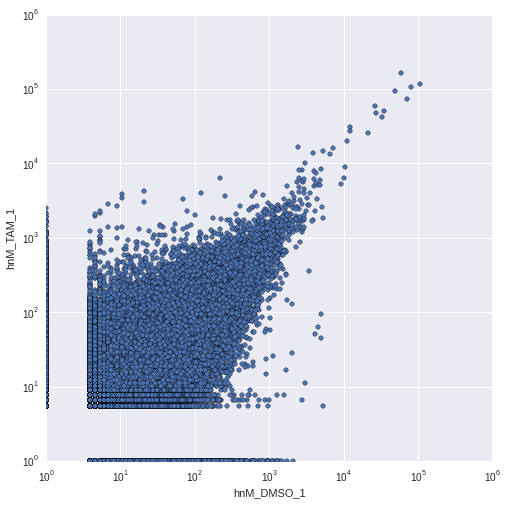

In [87]:
%%time
####Now bring in the code used above for the clipper clusters
#save the dataframes as beds
df_list = [hnM_DMSO_RT_df,hnM_TAM_RT_df]
file_names = ['hnM_DMSO','hnM_TAM']
counter = 0
for df in df_list:
    df.to_csv(file_names[counter]+'_normalized.bed',sep='\t',index = False,header = False)
    counter += 1

#now merge together into new clusters based on 20 nucleotides (This is what the Black RbFox paper did)
#PROBLEM - NOT COMBINING THE DATA CORRECTLY... there are clusters associated with multiple strands and multiple genes. SOLUTION - use -s

!bedtools merge -i hnM_DMSO_normalized.bed -d 20 -c 4,5,7,8 -o distinct,distinct,sum,sum -s > hnM_DMSO_normalized_merge.bed
!bedtools merge -i hnM_TAM_normalized.bed -d 20 -c 4,5,7,8 -o distinct,distinct,sum,sum -s > hnM_TAM_normalized_merge.bed

#now overlap the different samples. Black Rbfox paper took intersecting clusters and compared the read count between only those that intersected. There was no information about the clusters that did not intersect. 

#now I need to merge the DMSO and TAM merged clusters so that I can have a common set of clusters
#To do this, concat together the merges and then remerge but do not have a d
#NOTE THIS ONLY WORKS WITH BEDTOOLS VERSION 2.25.0
reset_after_bedtools_merge('hnM_DMSO_normalized_merge.bed')
reset_after_bedtools_merge('hnM_TAM_normalized_merge.bed')
!cat hnM_DMSO_normalized_merge.bed hnM_TAM_normalized_merge.bed > hnM_DMSO_TAM.bed
!bedtools sort -i hnM_DMSO_TAM.bed > hnM_DMSO_TAM_sorted.bed
!bedtools merge -i hnM_DMSO_TAM_sorted.bed -c 4,5,7,8 -o distinct,distinct,sum,sum -s > hnM_DMSO_TAM_sorted_merged.bed
reset_after_bedtools_merge('hnM_DMSO_TAM_sorted_merged.bed')

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples

pseudocount = 1

header_list=['chrom','start','end','ens_gene','blank','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+pseudocount,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+pseudocount,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+pseudocount,2)-log(row['hnM_DMSO']+pseudocount,2)),axis=1)

#Plot in Matplotlib and compute pearson correlation coefficient
ax = hnM_DMSO_TAM_final_union_df.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1',figsize=(8,8),loglog=True,\
                                 xlim=(1,10e5),ylim=(1,10e5))

#compute pearson correlation between each column
print(hnM_DMSO_TAM_final_union_df.corr())

In [88]:
hnM_DMSO_TAM_final_union_df.head()

,chrom,start,end,ens_gene,blank,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO
0,chr1,251639,251647,ENSG00000228463,0,-,9.420315,0.000000,10.420315,1.000000,-3.381327
1,chr1,564514,564515,ENSG00000225972,0,+,0.000000,5.691002,1.000000,6.691002,2.742222
2,chr1,564595,564596,ENSG00000225972,0,+,5.072477,0.000000,6.072477,1.000000,-2.602285
3,chr1,564722,564767,ENSG00000225972,0,+,0.000000,80.812229,1.000000,81.812229,6.354245
4,chr1,565245,565246,ENSG00000225630,0,+,0.000000,7.967403,1.000000,8.967403,3.164690


In [89]:
%%time
#get the gene expression file ready

#now it is time to load the gene expression data
twist_gene_exp_df = pd.read_csv('twist_gene_exp.diff',sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','twist_d0_fpkm','twist_d14_fpkm'])

#add a row with twist_d0_d14_fpkm_sum
twist_gene_exp_df['twist_d0_d14_fpkm_sum'] = twist_gene_exp_df.apply(lambda row: row['twist_d0_fpkm']+row['twist_d14_fpkm'],axis=1)

#we want to calculate TPM
#Equation from Harold Pimentel's blog: exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
#Do I need to add a pseudocount here?

pseudocount = 1

twist_d0_fpkm_sum = twist_gene_exp_df.twist_d0_fpkm.sum()
twist_d14_fpkm_sum = twist_gene_exp_df.twist_d14_fpkm.sum()
twist_gene_exp_df['twist_d0_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d0_fpkm']+pseudocount)-np.log(twist_d0_fpkm_sum) + np.log(1e6)),axis=1)
twist_gene_exp_df['twist_d14_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d14_fpkm']+pseudocount)-np.log(twist_d14_fpkm_sum) + np.log(1e6)),axis=1)


#add in the length of the gene as calulated by cufflinks

twist_gene_exp_df['chr'] = twist_gene_exp_df['gene_coords'].str.split(':').str[0]
twist_gene_exp_df['coords'] = twist_gene_exp_df['gene_coords'].str.split(':').str[1]
twist_gene_exp_df['gene_length'] = twist_gene_exp_df['coords'].str.split('-').str[1].astype(int) - twist_gene_exp_df['coords'].str.split('-').str[0].astype(int)


#Try plotting the fpkm distribution in each of these - I did this in cummerbund in R

#also bring in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
twist_gene_exp_df = pd.merge(twist_gene_exp_df,gene_name_and_biotype_df,on='ens_gene',how='left')

#collect a dictionary with ens_gene and length for use later. Name gene_and_length_dict
gene_and_length = twist_gene_exp_df[['ens_gene','gene_length']]
gene_and_length.to_csv('ens_gene_and_length',sep='\t',index=False,header=False)
gene_and_length_dict = {}
with open('ens_gene_and_length') as f:
    for line in f:
        line = line.strip().split('\t')
        gene_and_length_dict[line[0]] = line[1]
        
#collect a dictionary with ens_gene and summed expression in both cells
gene_and_fpkm_sum = twist_gene_exp_df[['ens_gene','twist_d0_d14_fpkm_sum']]
gene_and_fpkm_sum.to_csv('ens_gene_and_fpkm_sum',sep='\t',index=False,header=False)
gene_and_fpkm_sum_dict = {}
with open('ens_gene_and_fpkm_sum') as f:
    for line in f:
        line = line.strip().split('\t')
        gene_and_fpkm_sum_dict[line[0]] = float(line[1])


CPU times: user 4.08 s, sys: 16 ms, total: 4.1 s
Wall time: 4.16 s


In [90]:
%%time
#PROBLEM - now I need to merge the dataframes based on the column ens_gene. The problem is that ens_gene is not unique, so there is a loss of clusters
#SOLUTION - Take most highly expressed gene based on sum of twist_d0_fpkm and twist_d14_fpkm
with open('hnM_DMSO_TAM_sorted_merged.bed') as f:
    f = f.readlines()
    out_list = []
    for line in f:
        line = line.strip().split('\t')
        if ',' in line[3]:
            genes = line[3].split(',')
            gene_list = []
            sums_list = []
            for item in genes:
                if item in gene_and_fpkm_sum_dict.keys():
                    gene_list.append((item,gene_and_fpkm_sum_dict[item]))
                    sums_list.append(gene_and_fpkm_sum_dict[item])
            max_sum = max(sums_list)
            for item in gene_list:
                if item[1] == max_sum:               
                    line[3]=item[0]
        out_list.append(line)
with open('hnM_DMSO_TAM_sorted_merged_highest_expression_filtered.bed','w') as f:
    writer = csv.writer(f,'textdialect')
    writer.writerows(out_list)

ValueError: max() arg is an empty sequence

In [ ]:
%%time
#Bring in the gene expression normalization stuff from master dataframe script here

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
#Pseudocount of choice here
pseudocount = 1

header_list=['chrom','start','end','ens_gene','blank','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged_highest_expression_filtered.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+pseudocount,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+pseudocount,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+pseudocount,2)-log(row['hnM_DMSO']+pseudocount,2)),axis=1)

#This merge command just keeps all of the columns that agree on ens_gene and we lose clusters that do not match
#We lose clusters that do not match
#THIS IS KEY - WE ARE LOSING TOO MUCH
merge_df = pd.merge(hnM_DMSO_TAM_final_union_df,twist_gene_exp_df,on='ens_gene',how='left')

#add a cluster_id column at the front
merge_df['cluster_id']= merge_df.chrom.str.cat(merge_df.start.astype('str'),sep=':')
merge_df['cluster_id']= merge_df.cluster_id.str.cat(merge_df.end.astype('str'),sep='-')
cluster_id = merge_df['cluster_id']
merge_df.drop(labels=['cluster_id'], axis=1,inplace = True)
merge_df.insert(0, 'cluster_id', cluster_id)

#now add a column with +1 for each and log2ratio

pseudocount = 1

merge_df['twist_d0_fpkm_1'] = merge_df.apply(lambda row: row['twist_d0_fpkm']+pseudocount,axis=1)
merge_df['twist_d14_fpkm_1'] = merge_df.apply(lambda row: row['twist_d14_fpkm']+pseudocount,axis=1)
merge_df['log2ratio_fpkm_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14_fpkm']+pseudocount,2)-log(row['twist_d0_fpkm']+pseudocount,2)),axis=1)


#Add pseudocount and calculate log 2 ratio (tpm)
# merge_df['twist_d0_tpm_1'] = merge_df.apply(lambda row: row['twist_d0_tpm']+1,axis=1)
# merge_df['twist_d14_tpm_1'] = merge_df.apply(lambda row: row['twist_d14_tpm']+1,axis=1)
# merge_df['log2ratio_tpm_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14_tpm']+1,2)-log(row['twist_d0_tpm']+1,2)),axis=1)


#Notes on how to use this
#Here we take the non-pseudocount values for binding and the pseudocount+1 for gene expression and divide 
#non-pseudocount binding / pseudocount gene expression from that same sample. This is to prevent division by 0
#Then add the pseudocount of 1 to this value so you can plot on log scale

#now divide by the gene expression in each sample 
#with gene expression normalization - make sure to only use dataframe with genes that are expressed in at least one 
#condition at threshold

#Am I doing this correctly?
#This is for normalization based on FPKM 
#DO NOT ADD 1 HERE TO THE clip_gene_fpkm_norm value. Instead just add it for the log2 ratio. We want to keep the actual measurement as close to TRUE as possible
#REMEMBER - YOU MUST ADD 1 BEFORE PLOTTING SINCE YOU ARE PLOTTING ON THE LOG SCALE

pseudocount = 1

merge_df['hnM_DMSO_clip_gene_fpkm_norm']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_fpkm_1'])),axis=1)
merge_df['hnM_TAM_clip_gene_fpkm_norm'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_fpkm_1'])),axis=1)
merge_df['hnM_DMSO_clip_gene_fpkm_norm_1']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_fpkm_1'])+pseudocount),axis=1)
merge_df['hnM_TAM_clip_gene_fpkm_norm_1'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_fpkm_1'])+%pseudocount),axis=1)
#This is for normalization based on TPM
# merge_df['hnM_DMSO_clip_gene_tpm_norm']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_tpm_1'])),axis=1)
# merge_df['hnM_TAM_clip_gene_tpm_norm'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_tpm_1'])),axis=1)
# merge_df['hnM_DMSO_clip_gene_tpm_norm_1']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_tpm_1'])+1),axis=1)
# merge_df['hnM_TAM_clip_gene_tpm_norm_1'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_tpm_1'])+1),axis=1)

#calculate log2ratio of these
#What pseudocount to use here - find the minimum
#Here add the pseudocount
pseudocount = 1
merge_df['log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm'] = merge_df.apply(lambda row:(log(row['hnM_TAM_clip_gene_fpkm_norm']+pseudocount,2)-log(row['hnM_DMSO_clip_gene_fpkm_norm']+pseudocount,2)),axis=1)
merge_df['log2ratio_hnM_TAM_DMSO_gene_tpm_norm'] = merge_df.apply(lambda row:(log(row['hnM_TAM_clip_gene_tpm_norm']+pseudocount,2)-log(row['hnM_DMSO_clip_gene_tpm_norm']+pseudocount,2)),axis=1)


In [ ]:
#Gene Expression Tuning - Insert Value Here

#Keep rows with FPKM threshold or more in at least one sample
#Make sure that you use "or" because you want FPKM 5 in at least one sample
fpkm_threshold = 5
merge_df_high_genes = merge_df[(merge_df.twist_d0_fpkm >= fpkm_threshold) | (merge_df.twist_d14_fpkm >= fpkm_threshold)]

#Or use a TPM threshold - not implemented yet

#print how many clusters are lost of gained with each method
print('before gene expression cutoff ',len(merge_df))
print('\n')
print('after gene expression cutoff ',len(merge_df_high_genes))